In [5]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# params

In [6]:
CL = "hob"
PREFIX = "reg.all.2tasks.posonly"
DATA_PATH = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX}"
DATA_PATH_SCALED = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/reg.all_scaled.10epochs"

In [7]:
os.chdir(DATA_PATH)

# load predictions
PRED = f'DeepSTARR_ATAC.{PREFIX}.test.predictions.tsv'
TEST = f"{PREFIX}.Sequences_activity_Test.txt"
DIFF_ACC = f"/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results/{CL}_deseq2-nondiff.in.diffAcc.bed"
TEST_CHR = "chr8"

SCALED = True

# load data

In [9]:
DATA_PATH

'/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/reg.all.2tasks.posonly'

## predictions

In [10]:
pred = pd.read_csv(PRED, sep='\t', skiprows =1, names =["pred0", "pred1"])
print(pred.shape)
pred.head()

(2472, 2)


,pred0,pred1
0,-0.618647,-0.268544
1,-0.071015,0.152302
2,0.039737,0.161325
3,-0.331762,-0.116001
4,-0.359698,0.267086


## test data

In [11]:
test = pd.read_csv(TEST, sep='\t')
test["type"] = test["coor.type"].apply(lambda x: x.split("|")[0])

print(test.shape)
test.head()

(2472, 4)


,coor.type,ctrl,US_DIF,type
0,hob.78885|chr8:96922113-96922384,4.313066,-0.212668,hob.78885
1,hob.129142|chr8:22255532-22255803,4.129977,-0.079426,hob.129142
2,hob.39664|chr8:79383680-79383951,3.590894,-0.423753,hob.39664
3,hob.69376|chr8:98085638-98085909,4.559736,-0.210317,hob.69376
4,hob.130636|chr8:2030619-2030890,3.936475,-0.071077,hob.130636


In [12]:
if SCALED is True:
    sc = StandardScaler()
    test_scaled = pd.DataFrame(sc.fit_transform(test[["US_DIF", "ctrl"]].copy()), 
                              columns = ['US_DIF_scaled', "ctrl_scaled"])
    
    test_scaled = pd.merge(test, test_scaled, left_index=True, right_index=True)

test_scaled

,coor.type,ctrl,US_DIF,type,US_DIF_scaled,ctrl_scaled
0,hob.78885|chr8:96922113-96922384,4.313066,-0.212668,hob.78885,-0.048759,-0.870828
1,hob.129142|chr8:22255532-22255803,4.129977,-0.079426,hob.129142,0.823341,-1.005179
2,hob.39664|chr8:79383680-79383951,3.590894,-0.423753,hob.39664,-1.430368,-1.400758
3,hob.69376|chr8:98085638-98085909,4.559736,-0.210317,hob.69376,-0.033374,-0.689822
4,hob.130636|chr8:2030619-2030890,3.936475,-0.071077,hob.130636,0.877989,-1.147170
...,...,...,...,...,...,...
2467,hob.86261|chr8:38549281-38549552,3.899321,-0.194319,hob.86261,0.071335,-1.174434
2468,hob.62113|chr8:102375506-102375777,4.886568,-0.204025,hob.62113,0.007812,-0.449992
2469,hob.22088|chr8:23850416-23850687,4.802690,-0.344270,hob.22088,-0.910129,-0.511542
2470,hob.102019|chr8:120668872-120669143,5.602919,-0.092790,hob.102019,0.735871,0.075666


## merge all data

In [13]:
pt = pd.merge(test_scaled, pred, left_index=True, right_index=True)
pt["diff_acc"]=False

In [14]:
pt.corr()

,ctrl,US_DIF,US_DIF_scaled,ctrl_scaled,pred0,pred1,diff_acc
ctrl,1.000000,0.381195,0.381195,1.000000,0.547470,0.245504,NaN
US_DIF,0.381195,1.000000,1.000000,0.381195,0.175588,0.108736,NaN
US_DIF_scaled,0.381195,1.000000,1.000000,0.381195,0.175588,0.108736,NaN
ctrl_scaled,1.000000,0.381195,0.381195,1.000000,0.547470,0.245504,NaN
pred0,0.547470,0.175588,0.175588,0.547470,1.000000,0.633748,NaN
pred1,0.245504,0.108736,0.108736,0.245504,0.633748,1.000000,NaN
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN


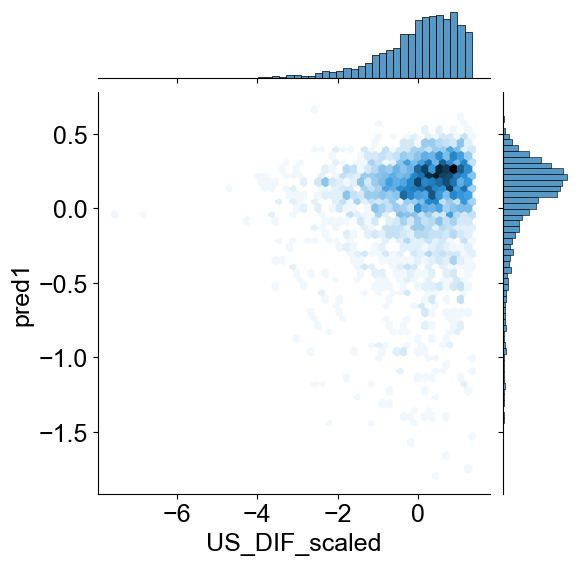

In [15]:
sns.jointplot(x="US_DIF_scaled", y="pred1", data=pt, kind="hex")

In [16]:
dif_acc = pd.read_csv(DIFF_ACC, sep='\t', header=None, 
                      names=["#chr_da", "start_da", "end_da", "id_da", 
                      "#chr_peak","start_peak", "end_peak", "type" ]
                     )
# get true differentially accessible peaks 
test_dif_acc = set(dif_acc.loc[dif_acc["#chr_peak"] == TEST_CHR, "type"])

# annotate ids that are differentially accessible according to DESEQ2
pt.loc[pt["type"].isin(test_dif_acc), "diff_acc"] = True

In [17]:
len(test_dif_acc)

81

## compute score differences

In [19]:
#pt["ctrl-us"]= pt["ctrl_scaled"] - pt["US_scaled"]
#pt["pred_ctrl-pred_us"]= pt["pred_ctrl"] - pt["pred_US"]

## correlation between predictions

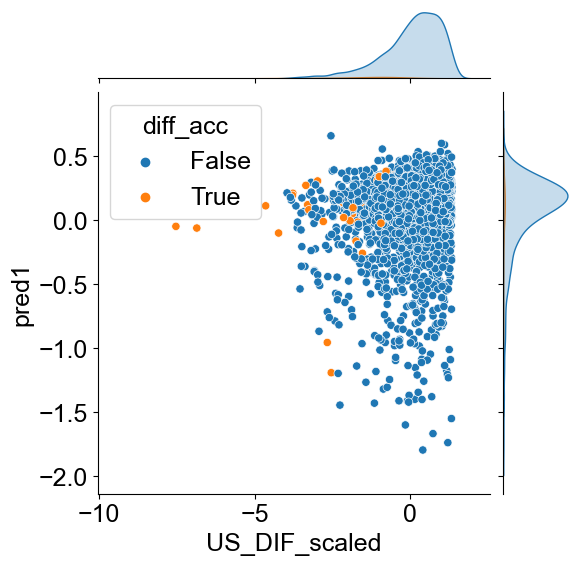

In [21]:
sns.jointplot(x="US_DIF_scaled", y="pred1", data=pt, hue = "diff_acc"
              #kind="hex"
             )

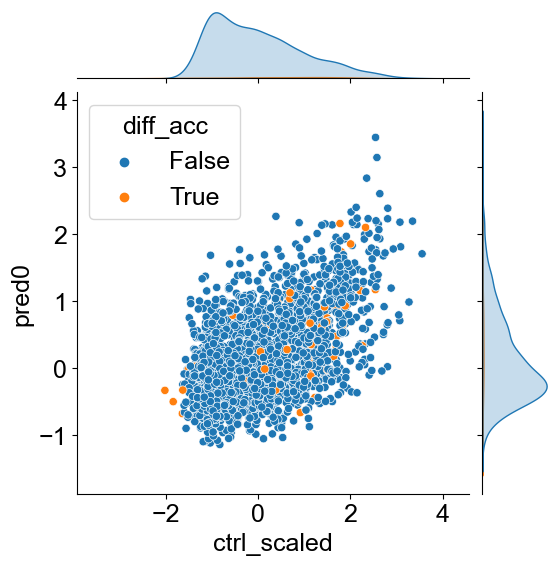

In [22]:
sns.jointplot(x="ctrl_scaled", y="pred0", data=pt,  hue = "diff_acc"
             # kind="hex"
             )

<AxesSubplot:xlabel='ctrl-us', ylabel='pred_ctrl-pred_us'>

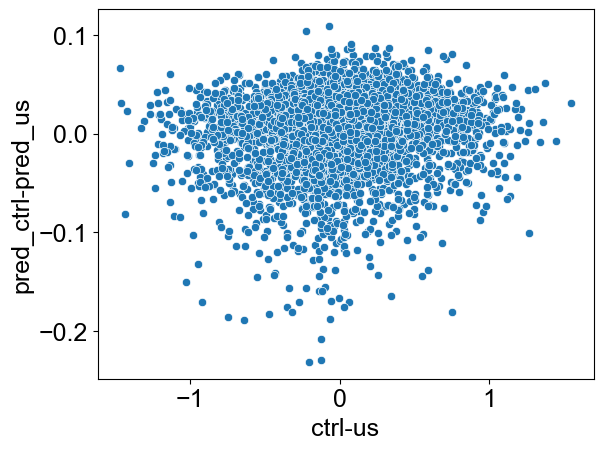

In [23]:
x = "ctrl-us"
y = "pred_ctrl-pred_us"
sns.scatterplot(x=x,y=y, data=pt)

## evaluate diff accessible

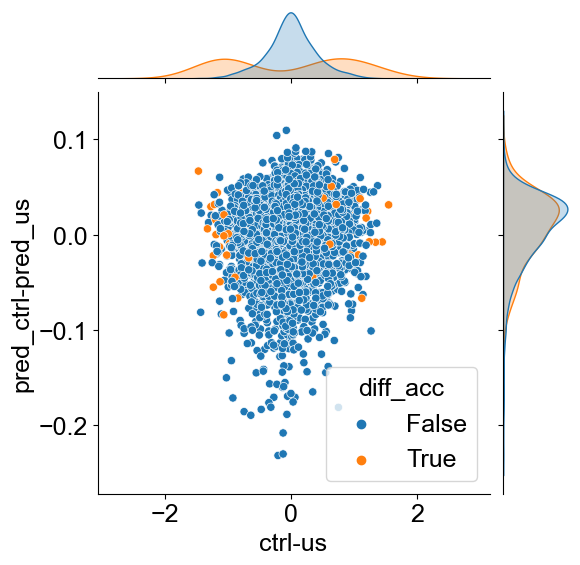

In [28]:
sns.jointplot(x=x,y=y, data=pt, hue="diff_acc", marginal_kws={"common_norm":False})

In [29]:
pt.loc[pt["diff_acc"]==True].corr()

,US,ctrl,US_scaled,ctrl_scaled,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.537837,1.000000,0.537837,0.419272,0.414859,NaN,-0.271611,0.058642
ctrl,0.537837,1.000000,0.537837,1.000000,0.449556,0.453347,NaN,0.665274,0.201246
US_scaled,1.000000,0.537837,1.000000,0.537837,0.419272,0.414859,NaN,-0.271611,0.058642
ctrl_scaled,0.537837,1.000000,0.537837,1.000000,0.449556,0.453347,NaN,0.665274,0.201246
pred_US,0.419272,0.449556,0.419272,0.449556,1.000000,0.998253,NaN,0.141898,0.282383
pred_ctrl,0.414859,0.453347,0.414859,0.453347,0.998253,1.000000,NaN,0.150134,0.338572
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.271611,0.665274,-0.271611,0.665274,0.141898,0.150134,NaN,1.000000,0.177805
pred_ctrl-pred_us,0.058642,0.201246,0.058642,0.201246,0.282383,0.338572,NaN,0.177805,1.000000


In [26]:
pt.loc[pt["diff_acc"]==True].corr(method="spearman")

,US,ctrl,US_scaled,ctrl_scaled,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.476403,1.000000,0.476403,0.359745,0.346310,NaN,-0.377211,0.103786
ctrl,0.476403,1.000000,0.476403,1.000000,0.405516,0.403459,NaN,0.607467,0.240273
US_scaled,1.000000,0.476403,1.000000,0.476403,0.359745,0.346310,NaN,-0.377211,0.103786
ctrl_scaled,0.476403,1.000000,0.476403,1.000000,0.405516,0.403459,NaN,0.607467,0.240273
pred_US,0.359745,0.405516,0.359745,0.405516,1.000000,0.997537,NaN,0.067541,0.566697
pred_ctrl,0.346310,0.403459,0.346310,0.403459,0.997537,1.000000,NaN,0.070490,0.598068
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.377211,0.607467,-0.377211,0.607467,0.067541,0.070490,NaN,1.000000,0.128275
pred_ctrl-pred_us,0.103786,0.240273,0.103786,0.240273,0.566697,0.598068,NaN,0.128275,1.000000


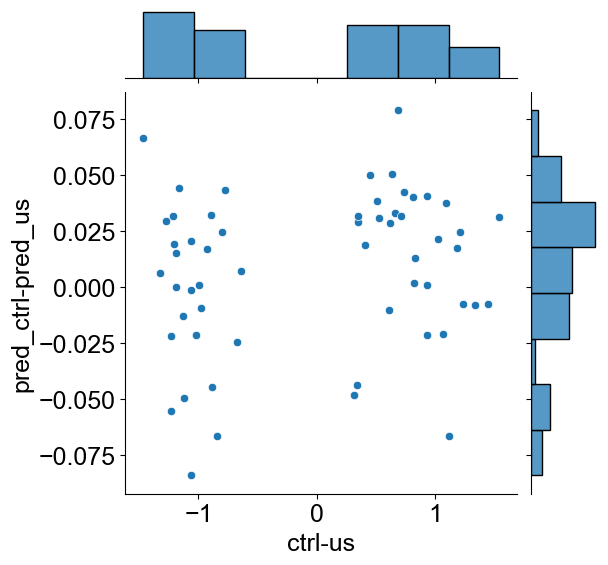

In [27]:
sns.jointplot(x=x,y=y, data=pt.loc[pt["diff_acc"]==True], marginal_kws={"common_norm":False})